# Flying Mantines

ModSim Project 3

Lydia Hodges and Chase Joyner

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)

In [1]:
%matplotlib inline

from modsim import *

In [6]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
degree = UNITS.degree
radian = UNITS.radian

In [10]:
condition = Condition(x = 0 * m, 
                      y = 0 * m,
                      g = 9.8 * m/s**2,
                      diameter = 6.7 * m,
                      mass = 1350 * kg,
                      rho = 1.2 * kg/m**3,
                      angle = 60 * degree,
                      den = 1000 * kg/m**3,
                      C_d = 1.28 * np.sin(angle),
                      C_l = 2 * np.pi * angle,
                      wing_area = 14.14 * m**2,
                      velocity = 6.7 * m / s,
                      bh = 4.9 * m,
                      duration = 1 * s)
angle_array = linrange(30, 90, 1)

In [11]:
def make_system(condition):
    
    unpack(condition)
    
    # convert angle to degrees
    theta = np.deg2rad(angle)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, velocity)
    
    # make the initial state
    init = State(x=x, y=y, vx=vx, vy=vy)
    
    # compute area from diameter
    area = np.pi * (diameter/2)**2
    
    # compute timestamps
    ts = linspace(0, duration, 101)
    
    return System(init=init, g=g, mass=mass, 
                  area=area, rho=rho, C_d=C_d, ts=ts)

In [12]:
system = make_system(condition)

In [13]:
def slope_func(state, t, system):
    
    x, y, vx, vy = state
    unpack(system)
    
    a_grav = Vector(0, -g)

    v = Vector(vx, vy)
    
    f_drag = -C_d * wing_area * rho * (velocity**2 / 2)
    a_drag = f_drag / mass
    
    f_lift = C_l * wing_area * rho * (velocity**2 / 2)
    a_lift = f_lift / mass
    
    a = a_grav + a_drag + a_lift
    
    return vx, vy, a.x, a.y

In [14]:
slope_func(system.init, 0, system)

(<Quantity(3.350000000000001, 'meter / second')>,
 <Quantity(5.802370205355738, 'meter / second')>,
 <Quantity(1.543479880467828, 'meter / second ** 2')>,
 <Quantity(-8.256520119532173, 'meter / second ** 2')>)

In [15]:
run_odeint(system, slope_func)
print(system.results)

             x         y        vx        vy
0.00  0.000000  0.000000  3.350000  5.802370
0.01  0.033577  0.057611  3.365435  5.719805
0.02  0.067309  0.114396  3.380870  5.637240
0.03  0.101195  0.170356  3.396304  5.554675
0.04  0.135235  0.225490  3.411739  5.472109
0.05  0.169429  0.279798  3.427174  5.389544
0.06  0.203778  0.333280  3.442609  5.306979
0.07  0.238282  0.385937  3.458044  5.224414
0.08  0.272939  0.437769  3.473478  5.141849
0.09  0.307751  0.488774  3.488913  5.059283
0.10  0.342717  0.538954  3.504348  4.976718
0.11  0.377838  0.588309  3.519783  4.894153
0.12  0.413113  0.636837  3.535218  4.811588
0.13  0.448542  0.684541  3.550652  4.729023
0.14  0.484126  0.731418  3.566087  4.646457
0.15  0.519864  0.777470  3.581522  4.563892
0.16  0.555757  0.822696  3.596957  4.481327
0.17  0.591803  0.867096  3.612392  4.398762
0.18  0.628004  0.910671  3.627826  4.316197
0.19  0.664360  0.953420  3.643261  4.233631
0.20  0.700870  0.995344  3.658696  4.151066
0.21  0.73

Saving figure to file Proj3_SingleRun.pdf


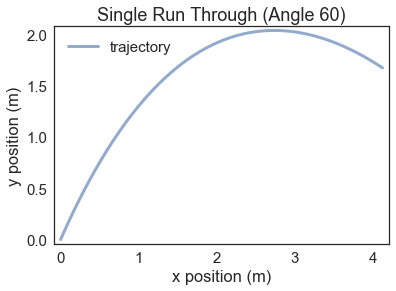

In [16]:
xs = system.results.x
ys = system.results.y
newfig()
plot(xs, ys, label='trajectory')
decorate(xlabel='x position (m)',
         ylabel='y position (m)',
        title='Single Run Through (Angle 60)')
savefig('Proj3_SingleRun.pdf')

In [19]:
def sweep_param(angle_array, system):
    newfig()
    decorate(xlabel='x position (m)',
             ylabel='y position (m)',
            title='Sweep Angle (30 - 90)')
    for ang in angle_array:
        condition.set(angle=ang)
        system = make_system(condition)
        run_odeint(system, slope_func)
        xs = system.results.x
        ys = system.results.y
        plot(xs, ys)
        print(angle)
    savefig('Proj3_SweepAngle.pdf')

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
Saving figure to file Proj3_SweepAngle.pdf


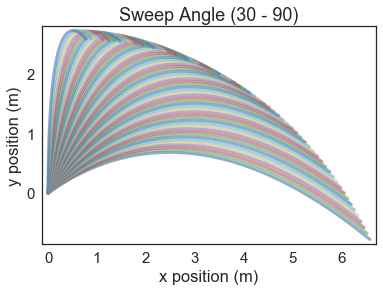

In [20]:
sweep_param(angle_array, system)

In [309]:
def run_sim(state, system):
    
    run_odeint(system, slope_func)
    h = system.results.y.loc(1.5)
    f = slope_func(system.init, h, system)
    acc = sqrt((f.a.x)**2 + (f.a.y)**2)
    force = mass * acc
    print(force)

In [93]:
run_sim(system.init, system)

AttributeError: 'tuple' object has no attribute 'a'